## Distribution of Admix

In [24]:
import pandas as pd
import seaborn as sns
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import re

# Set font preferences
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 8

# Directories
gold_standard_xeno_dir = r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\spOT-NMF\Raw_Data\gold_standard_xeno_fig6"

# Load and preprocess data
df_admix = pd.read_csv(r"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\simulation\stats\sample_obs.csv", index_col=0)
df_admix['sample_id'] = df_admix['sample_id'].apply(lambda x: x.replace("um_ctrl", "").replace("_i_", "_").replace("BT143_", ""))
df_admix = df_admix[df_admix['sample_id'].str.strip() != ''].copy()


C:\Users\alyos\AppData\Local\Temp\ipykernel_29932\3518057217.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


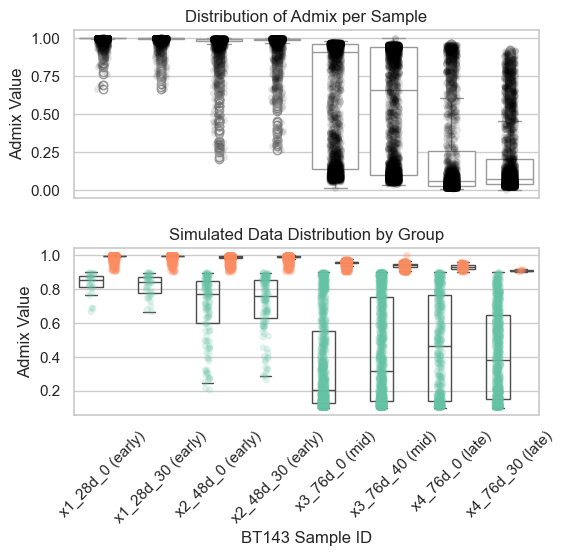

In [ ]:

# plt.figure(figsize=(8, 6))
# plt.scatter(df_admix['mm10'], df_admix['admix'], c='blue', marker='o', s=1, alpha=0.5)
# plt.xlabel('mm10 counts')
# plt.ylabel('admix')
# plt.title('Scatter Plot of mm10 vs admix')

# Add stage to sample_id
def add_stage_label(s):
    match = re.search(r'x(\d+)_', s)
    if match:
        x = int(match.group(1))
        if x in [1, 2]:
            stage = 'early'
        elif x == 3:
            stage = 'mid'
        elif x == 4:
            stage = 'late'
        else:
            stage = ''
        return f"{s} ({stage})" if stage else s
    return s

df_admix['sample_id'] = df_admix['sample_id'].apply(add_stage_label)

# Sorting for consistent x-axis
def extract_sample_number(s):
    match = re.search(r'x(\d+)_', s)
    return int(match.group(1)) if match else float('inf')

sorted_sample_ids = sorted(df_admix['sample_id'].unique(), key=extract_sample_number)

# Categorize admix
def categorize_admix(admix):
    if admix > 0.9:
        return 'sim_mm (> 0.9)'
    elif 0.1 < admix <= 0.9:
        return 'sim_TME (0.1 - 0.9)'
    else:
        return 'Excluded'

df_admix['admix_group'] = df_admix['admix'].apply(categorize_admix)
df_plot = df_admix[df_admix['admix_group'].isin(['sim_mm (> 0.9)', 'sim_TME (0.1 - 0.9)'])]

# Create subplot
fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True, gridspec_kw={'hspace': 0.3})

# First subplot
sns.boxplot(data=df_admix, x='sample_id', y='admix', order=sorted_sample_ids, color='white', ax=axes[0])
sns.stripplot(data=df_admix, x='sample_id', y='admix', order=sorted_sample_ids, color='black', jitter=True, alpha=0.1, ax=axes[0])
axes[0].set_title('Distribution of Admix per Sample')
axes[0].set_ylabel('Admix Value')

# Second subplot
sns.boxplot(data=df_plot, x='sample_id', y='admix', hue='admix_group',
            order=sorted_sample_ids, showcaps=True,
            boxprops={'facecolor': 'None'}, showfliers=False,
            whiskerprops={'linewidth': 0}, ax=axes[1])
sns.stripplot(data=df_plot, x='sample_id', y='admix', hue='admix_group',
              palette='Set2', order=sorted_sample_ids, dodge=True, jitter=True, alpha=0.2, ax=axes[1])

axes[1].set_title('Simulated Data Distribution by Group')
axes[1].set_ylabel('Admix Value')
axes[1].set_xlabel('BT143 Sample ID')
axes[1].tick_params(axis='x', rotation=45)

# Remove duplicate legends
axes[1].legend_.remove()

plt.tight_layout()
plt.savefig(os.path.join(gold_standard_xeno_dir, "samples_admix_combined.pdf"))
plt.show()


## Performance Summary

### 1. Load Metrics

In [ ]:
import os
import pandas as pd
import sys
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import scanpy as sc
import numpy as np

file_path = r"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\data\stereoseq_mouse_brain_li2023_sim_norm_mm\Mouse_brain_cell_bin.h5ad"
adata = sc.read_h5ad(file_path)
cell_types = adata.obs["annotation"].unique().tolist()



base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
data_dir = os.path.join(base_dir, "data")
results_dir = os.path.join(base_dir, "ismb_results_wassgard_xeno_v2_celltypes")
manuscript_dir = r'Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard'


# Helper function to shorten dataset names
def shorten_name(name):
    if name == "stereoseq_mouse_brain_li2023_sim_norm_mm":
        return "stereoseq_mouse_brain"
    return "_".join(name.split("_")[:5]).replace('_i_','')  # Keep only first 3 parts



dataset_list = [
    "BT143_x1_28d_i_0um_ctrl_tme",
    "BT143_x2_48d_i_0um_ctrl_tme",
    "BT143_x3_76d_i_0um_ctrl_tme",
    "BT143_x4_76d_i_0um_ctrl_tme",
    "BT143_x1_28d_i_30um_ctrl_tme",
    "BT143_x2_48d_i_30um_ctrl_tme", 
    "BT143_x3_76d_i_40um_ctrl_tme",
    "BT143_x4_76d_i_30um_ctrl_tme",
]


df_list = []
dataset = "stereoseq_mouse_brain_li2023_sim_norm_mm"
file_path = os.path.join(base_dir, "ismb_results_wassgard", dataset, "analysis", f"metrics_{dataset}.csv")
if os.path.exists(file_path):
    df_metrics = pd.read_csv(file_path)
    df_metrics["dataset"] = shorten_name(dataset)  # Add shortened name
    df_metrics["dataset_category"] = "original"
    df_metrics["cell_type_category"] = "original"
    df_metrics["source"] = "original"

    df_list.append(df_metrics)


def assign_category(row, cell_type):
    if row['celltype'] == cell_type:
        if 'x1' in row['dataset'] or 'x2' in row['dataset']:
            return 'sim_TME_early'
        else:
            return 'sim_TME_late'
    else:
        return 'sim_normal'
# def assign_category(row, cell_type):
#     if row['celltype'] == cell_type:
#         if 'x1' in row['dataset'] or 'x2' in row['dataset']:
#             return 'sim_TME_early'
#         else:
#             return 'sim_TME_late'
#     else:
#         if 'x1' in row['dataset'] or 'x2' in row['dataset']:
#             return 'sim_normal_early'
#         else:
#             return 'sim_normal_late'
# 

for base_dataset in dataset_list:
    for cell_type in cell_types:
        str_cell_type = cell_type.replace(' ','_').replace('/','_')
        dataset = f"{base_dataset}_{str_cell_type}"
        file_path = os.path.join(results_dir, dataset, "analysis", f"metrics_{dataset}.csv")
        if os.path.exists(file_path):
            df_metrics = pd.read_csv(file_path)
            df_metrics["dataset"] = shorten_name(dataset)  # Add shortened name
            df_metrics["dataset_category"] = "Xenograft" if dataset.startswith("BT143") else "original"
            df_metrics['cell_type_category'] = df_metrics.apply(assign_category, axis=1, cell_type=cell_type)
            df_metrics["source"] = cell_type
            df_list.append(df_metrics)


df_all = pd.concat(df_list, ignore_index=True)
df_all = df_all[df_all["experiment"] != "stdecon"]

C:\Users\alyos\AppData\Local\Temp\ipykernel_23668\819398269.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x_label_map[x] for x in x_order])
C:\Users\alyos\AppData\Local\Temp\ipykernel_23668\819398269.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x_label_map[x] for x in x_order])
C:\Users\alyos\AppData\Local\Temp\ipykernel_23668\819398269.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x_label_map[x] for x in x_order])
C:\Users\alyos\AppData\Local\Temp\ipykernel_23668\819398269.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x_label_map[x] for x in x_orde

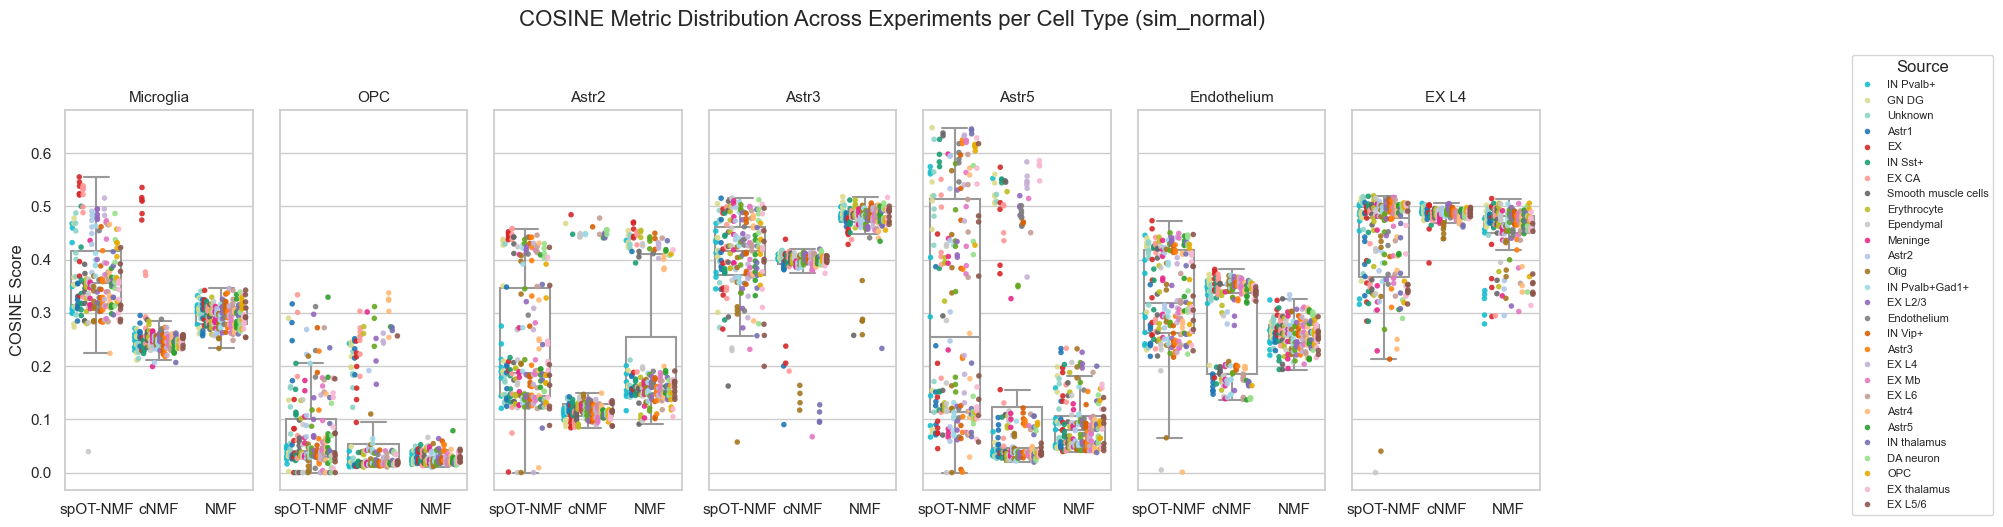

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Filter data ===
selected_cell_types = ["Microglia", "OPC", "Astr2", "Astr3", "Astr5", "Endothelium", "EX L4"]
subset = df_all[
    (df_all["cell_type_category"] == "sim_normal") &
    (df_all["celltype"].isin(selected_cell_types))
]
x_order = ["ot", "cnmf", "nmf"]
x_label_map = {"ot": "spOT-NMF", "cnmf": "cNMF", "nmf": "NMF"}

# === Define palette ===
unique_sources = sorted(subset["source"].unique())
base_palette = sns.color_palette("tab20", 20) + sns.color_palette("Dark2", 8) + sns.color_palette("Set3", 12)
palette = base_palette[:len(unique_sources)]
source_palette = dict(zip(unique_sources, palette))

# === Set up the plot ===
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, len(selected_cell_types), figsize=(18, 5), sharey=True)

# === Plot per celltype ===
for i, (ax, celltype) in enumerate(zip(axes, selected_cell_types)):
    cell_subset = subset[subset["celltype"] == celltype]

    # Boxplot
    sns.boxplot(
        data=cell_subset,
        x="experiment",
        y="COSINE",
        color="white",
        showfliers=False,
        linewidth=1.5,
        ax=ax
    )

    # Stripplot: hue for all plots
    strip = sns.stripplot(
        data=cell_subset,
        x="experiment",
        y="COSINE",
        hue="source",
        palette=source_palette,
        dodge=True,
        jitter=True,
        size=4,
        alpha=0.9,
        ax=ax
    )

    if i > 0:
        ax.get_legend().remove()  # Remove extra legends

    ax.set_title(celltype, fontsize=11)
    ax.set_xlabel("")
    ax.set_xticklabels([x_label_map[x] for x in x_order])
    if i > 0:
        ax.set_ylabel("")
        
axes[0].set_ylabel("COSINE Score")


# === Shared legend ===
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Source", bbox_to_anchor=(1.03, 0.5), loc="center left", fontsize=8)
axes[0].legend_.remove()

# === Add a main title ===
fig.suptitle("COSINE Metric Distribution Across Experiments per Cell Type (sim_normal)", fontsize=16, y=1.05)

# === Final layout ===
plt.tight_layout(rect=[0, 0, 0.87, 1])
plt.savefig(os.path.join(gold_standard_xeno_dir, "cosine_boxplots_subset_cell_types_sim_normal__update.pdf"))
plt.show()


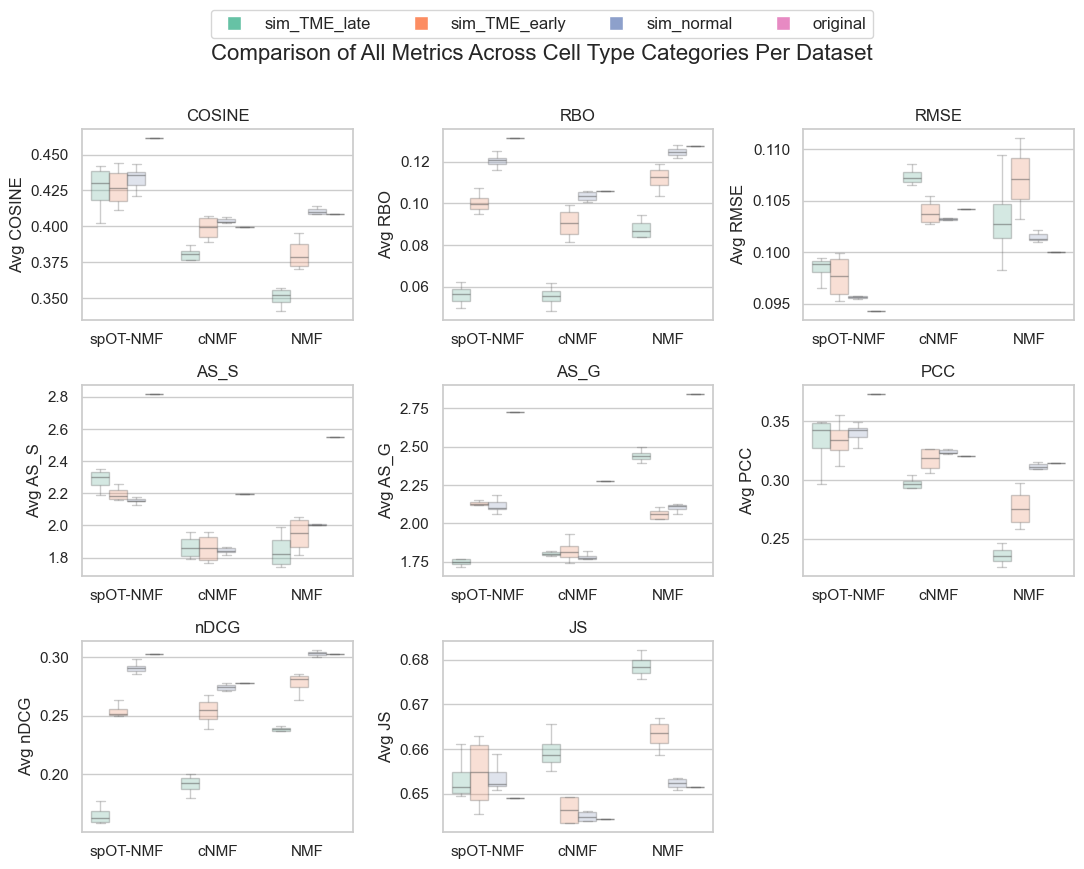

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from itertools import combinations

# === Inputs ===
metrics = ['COSINE', 'RBO', 'RMSE', 'AS_S', 'AS_G', 'PCC', 'nDCG', 'JS']
cell_type_categories = ['sim_TME_late', 'sim_TME_early', 'sim_normal', "original"]
x_order = ["ot", "cnmf", "nmf"]
x_label_map = {"ot": "spOT-NMF", "cnmf": "cNMF", "nmf": "NMF"}

# Convert p-value to significance stars
def pval_to_star(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'ns'

# Generic pairwise p-value calculator
def compute_pairwise_pvals(df, group_col, value_col, compare_col, metric_name):
    records = []
    for group_val in df[group_col].unique():
        subset = df[df[group_col] == group_val]
        cats = subset[compare_col].unique()
        for cat1, cat2 in combinations(cats, 2):
            vals1 = subset[subset[compare_col] == cat1][value_col].dropna()
            vals2 = subset[subset[compare_col] == cat2][value_col].dropna()
            if len(vals1) > 1 and len(vals2) > 1:
                stat, pval = ttest_ind(vals1, vals2, equal_var=False)
                label = f"{group_val}: {cat1} vs {cat2}"
                records.append([metric_name, label, pval, pval_to_star(pval)])
    return records

# Set up plot
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(11, 8.5), sharex=False, sharey=False)
fig.suptitle('Comparison of All Metrics Across Cell Type Categories Per Dataset', fontsize=16)
axes = axes.flatten()

pval_records = []

for i, metric in enumerate(metrics):
    avg_df = (
        df_all[df_all['cell_type_category'].isin(cell_type_categories)]
        .groupby(['dataset', 'experiment', 'cell_type_category'])[metric]
        .mean()
        .reset_index()
    )

    avg_df['experiment'] = pd.Categorical(avg_df['experiment'], categories=x_order, ordered=True)
    palette = dict(zip(cell_type_categories, sns.color_palette('Set2')))

    sns.boxplot(
        data=avg_df,
        x='experiment',
        y=metric,
        hue='cell_type_category',
        hue_order=cell_type_categories,
        showfliers=False,
        palette=[palette[cat] for cat in cell_type_categories],
        dodge=True,
        ax=axes[i],
        legend=False,
        boxprops=dict(alpha=0.3),
        whiskerprops=dict(alpha=0.3),
        capprops=dict(alpha=0.3),
        medianprops=dict(alpha=0.5),
    )

    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(f'Avg {metric}')
    axes[i].set_xlabel('')
    axes[i].set_xticks(range(len(x_order)))
    axes[i].set_xticklabels([x_label_map[x] for x in x_order])

    # === Pairwise within each experiment (method): early vs late vs normal
    pval_records += compute_pairwise_pvals(avg_df, 'experiment', metric, 'cell_type_category', metric)

    # === Pairwise across experiments: same cell type category
    pval_records += compute_pairwise_pvals(avg_df, 'cell_type_category', metric, 'experiment', metric)

# Remove unused subplots
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Add legend
handles = [
    Line2D([0], [0], marker='s', color='w', label=cat,
           markerfacecolor=palette[cat], markersize=10)
    for cat in cell_type_categories
]
fig.legend(
    handles,
    cell_type_categories,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.03),
    ncol=5,
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(gold_standard_xeno_dir, "gold_standard_metrics_all_pairwise_clean.pdf"))
plt.show()

# === Output p-values table
pval_df = pd.DataFrame(pval_records, columns=["Metric", "Comparison", "p-value", "Significance"])
pval_df.to_csv(os.path.join(gold_standard_xeno_dir, "gold_standard_metrics_all_pairwise_clean.csv"))


### 2. Explain Variance by spots

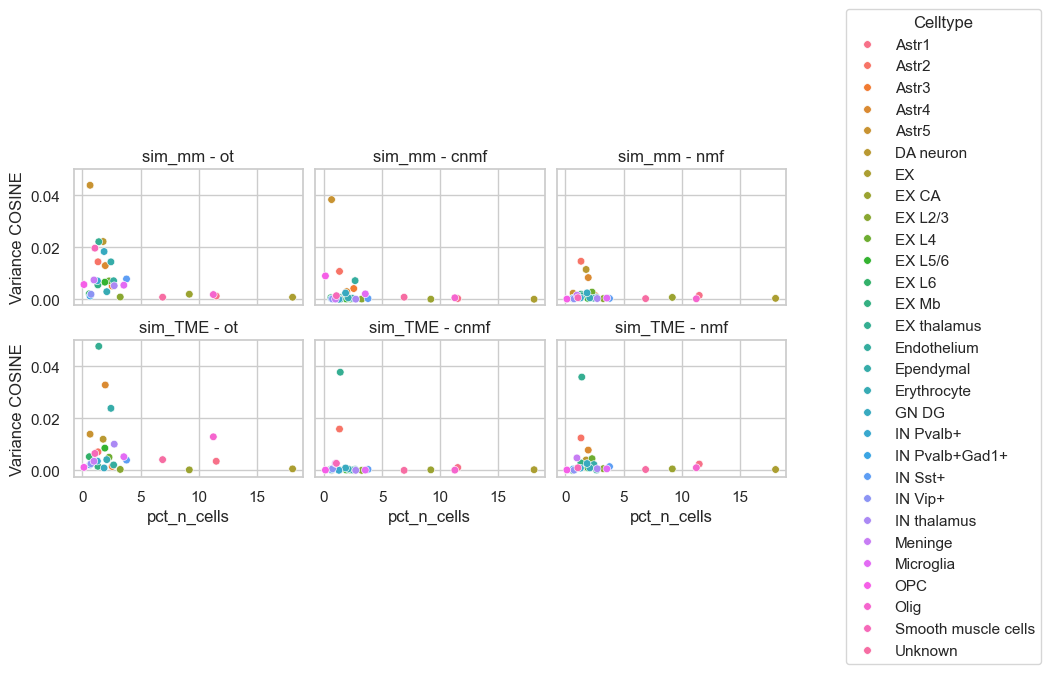

In [70]:
df_sparsity = pd.read_csv(r"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\ismb_results_wassgard\stereoseq_mouse_brain_li2023_sim_norm_mm\analysis\sparsity_{sample_name}.csv",index_col=0)

agg_df = df_all.groupby(['celltype', 'experiment', 'cell_type_category'])['COSINE'] \
           .agg(['mean', 'var']).reset_index()
joined_df = agg_df.join(df_sparsity, on='celltype', how='left')

# Ensure consistent order
experiments = ['ot', 'cnmf', 'nmf']
categories = ['sim_mm', 'sim_TME']

# Set up subplots grid
fig, axes = plt.subplots(len(categories), len(experiments), figsize=(8, 4), sharex=True, sharey=True)

# Plotting
for i, category in enumerate(categories):
    for j, experiment in enumerate(experiments):
        ax = axes[i, j] if len(categories) > 1 else axes[j]
        subset = joined_df[(joined_df['cell_type_category'] == category) & (joined_df['experiment'] == experiment)]
        
        sns.scatterplot(data=subset, x='pct_n_cells', y='var', hue='celltype', s=30, ax=ax)

        ax.set_title(f'{category} - {experiment}', fontsize=12)
        ax.set_xlabel('pct_n_cells')
        ax.set_ylabel('Variance COSINE')
        ax.legend().remove()

# Add a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Celltype', bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
# plt.savefig(os.path.join(r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data", "XenoBenchmark2", f"variance_scatter_cell_type_all_data_pct_n_cells.pdf"))
plt.savefig(os.path.join(gold_standard_xeno_dir, "cosine_variance_scatter_by_pct_n_cells_per_celltype.pdf"))

plt.show()



### 3. Supplmentry Metrics results per celltype

In [61]:
df_all['experiment_group'].value_counts()

experiment_group
ot_sim_normal_early      3248
cnmf_sim_normal_early    3248
nmf_sim_normal_early     3248
ot_sim_normal_late       3248
cnmf_sim_normal_late     3248
nmf_sim_normal_late      3248
ot_sim_TME_early          116
cnmf_sim_TME_early        116
nmf_sim_TME_early         116
ot_sim_TME_late           116
cnmf_sim_TME_late         116
nmf_sim_TME_late          116
ot_original                29
cnmf_original              29
nmf_original               29
Name: count, dtype: int64

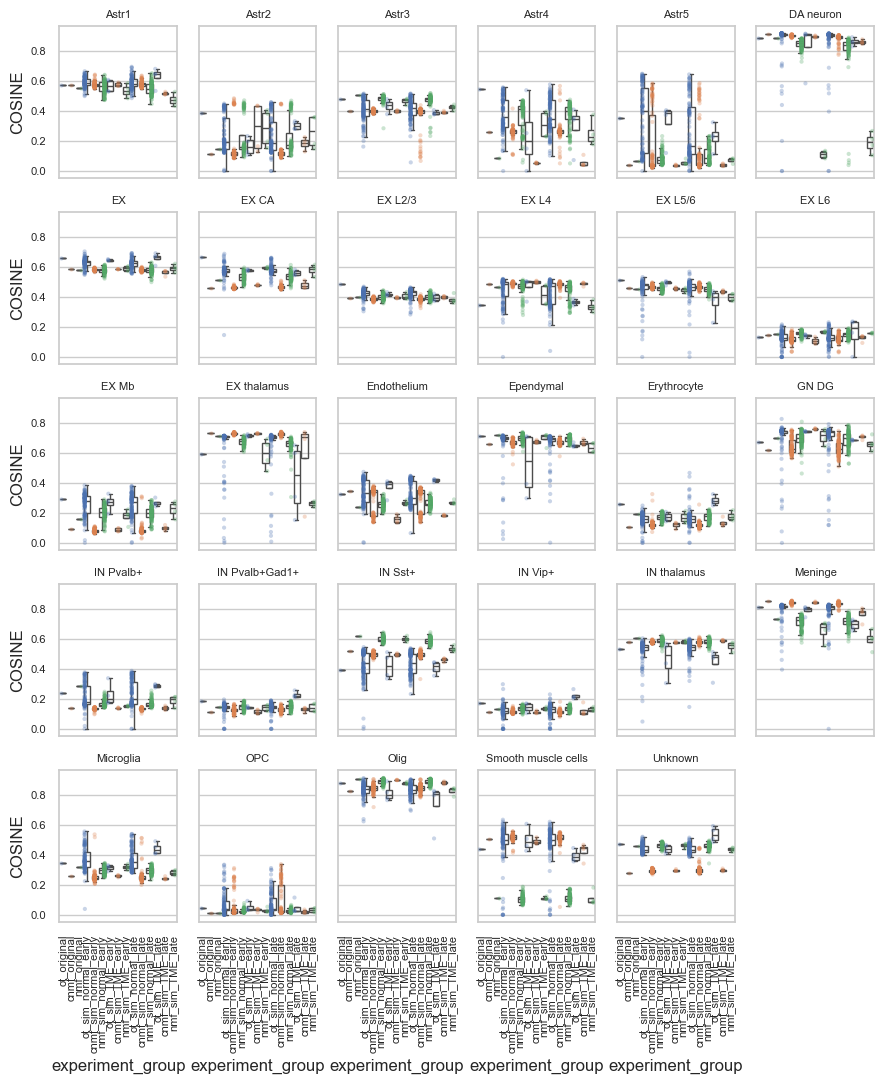

In [55]:

df_all['experiment_group'] = df_all['experiment'] + '_' + df_all['cell_type_category']
x_group_order = df_all.drop_duplicates('experiment_group').sort_values('cell_type_category')['experiment_group'].tolist()

# Get list of unique celltypes
celltypes = sorted(df_all['celltype'].unique())

fig, axes = plt.subplots(5, 6, figsize=(9, 11), sharex=True, sharey=True)
axes = axes.flatten()

# Remove extra axes
for ax in axes[len(celltypes):]:
    fig.delaxes(ax)

# Plot per celltype
for ax, celltype in zip(axes, celltypes):
    data = df_all[df_all['celltype'] == celltype]
    sns.stripplot(
        data=data, x='experiment_group', y='COSINE', hue='experiment', legend=False,
        dodge=True, jitter=True, alpha=0.3, ax=ax, size = 3
    )
    sns.boxplot(
        data=data, x='experiment_group', y='COSINE', hue='experiment', showfliers=False, legend=False,
        showcaps=True, boxprops={'facecolor': 'none'}, ax=ax
    )
    ax.set_title(f'{celltype}', fontsize=8)
    ax.tick_params(axis='x', labelrotation=90, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Tight layout and reduce spacing
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data", "XenoBenchmark2", f"boxplot_cell_type_all_data.pdf"))
plt.savefig(os.path.join(gold_standard_xeno_dir, "cosine_boxplots_all_cell_types_seperate_update.pdf"))

plt.show()


